In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
data = pd.read_csv('Motor DE(AD3278).csv')
print(data.head())

             timeStamp  temperature   Noise       RPM  Total Acceleration  \
0  16-05-2024 00:00:15       46.875  81.773  3076.172                2.65   
1  16-05-2024 00:01:16       46.875  81.098  3076.172                2.63   
2  16-05-2024 00:02:16       46.813  81.019  3076.172                2.64   
3  16-05-2024 00:03:16       46.813  81.695  3076.172                2.65   
4  16-05-2024 00:04:16       46.750  80.838  3076.172                2.61   

   Axial RMS Velocity  Horizontal RMS Velocity  Vertical RMS Velocity  \
0               4.089                    1.431                  7.066   
1               3.998                    1.367                  7.295   
2               3.991                    1.413                  7.248   
3               4.085                    1.309                  7.165   
4               4.034                    1.225                  7.111   

   Axial RMS Acceleration  Horizontal RMS Acceleration  \
0                   1.438               

In [ ]:
# Handle missing values: Fill NaN with 0
data.fillna(0, inplace=True)

# Extract features
features = data[['Axial RMS Velocity', 'Horizontal RMS Velocity', 'Vertical RMS Velocity']]
original_data = features.copy()  # Retain original data

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, idx_train, idx_test = train_test_split(features_scaled, features.index, test_size=0.3, random_state=42)


In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust the parameters
dbscan.fit(X_train)

# Add the cluster labels to the training data
train_labels = dbscan.labels_

# Store noise points from training data
noise_train_indices = np.where(train_labels == -1)[0]
noise_train_original_indices = idx_train[noise_train_indices]
noise_train =data.iloc[noise_train_original_indices]

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Function to predict cluster for a new data point
def predict_dbscan(dbscan_model, X_new):
    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True

    # Nearest neighbors classifier to classify non-core samples
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(dbscan_model.components_)

    y_new = np.full(X_new.shape[0], -1)  # Default to noise (-1)
    noise_indices = []

    for i, x in enumerate(X_new):
        distances, indices = nn.kneighbors([x], n_neighbors=1)
        if distances[0][0] <= dbscan_model.eps:
            y_new[i] = dbscan_model.labels_[dbscan_model.core_sample_indices_[indices[0][0]]]
        else:
            noise_indices.append(i)

    return y_new, noise_indices

# Predict cluster membership for the test data
test_labels, noise_test_indices = predict_dbscan(dbscan, X_test)
noise_test_original_indices = idx_test[noise_test_indices]
noise_test =data.iloc[noise_test_original_indices]


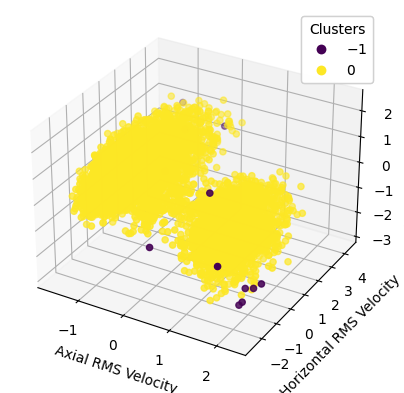

In [ ]:
# Combine the train and test data for visualization
combined_data = np.vstack((X_train, X_test))
combined_labels = np.concatenate((train_labels, test_labels))

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(combined_data[:, 0], combined_data[:, 1], combined_data[:, 2], c=combined_labels, cmap='viridis', marker='o')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('Axial RMS Velocity')
ax.set_ylabel('Horizontal RMS Velocity')
ax.set_zlabel('Vertical RMS Velocity')

plt.show()

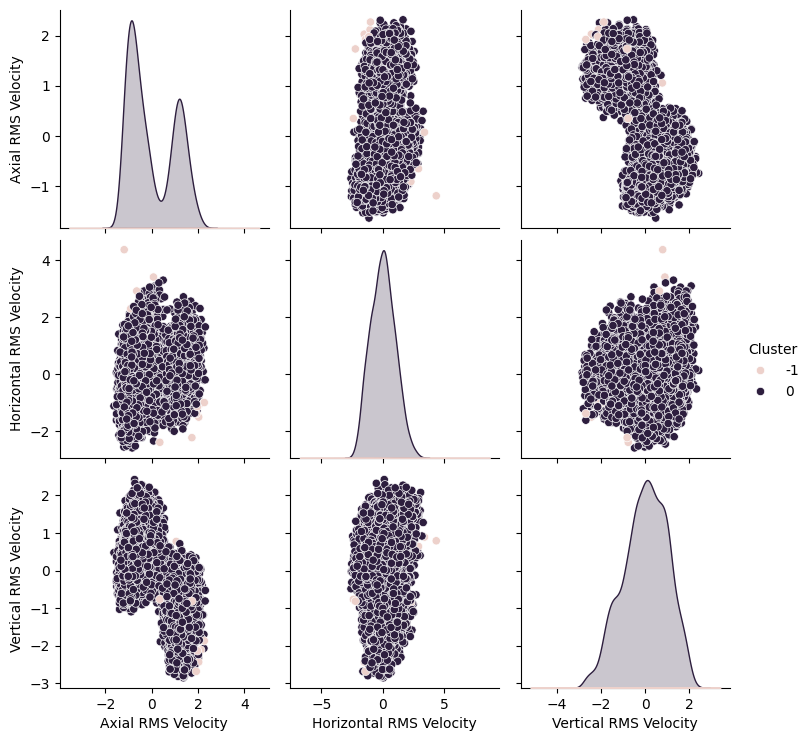

In [ ]:
df_combined = pd.DataFrame(combined_data, columns=['Axial RMS Velocity', 'Horizontal RMS Velocity', 'Vertical RMS Velocity'])
df_combined['Cluster'] = combined_labels

sns.pairplot(df_combined, hue='Cluster', vars=['Axial RMS Velocity', 'Horizontal RMS Velocity', 'Vertical RMS Velocity'])
plt.show()

In [ ]:
noise_data = pd.concat([noise_train, noise_test])
print("Noise data points:\n", noise_data)

Noise data points:
                 timeStamp  temperature   Noise       RPM  Total Acceleration  \
554   16-05-2024 09:54:51       47.500  81.890  3076.172                2.59   
2400  17-05-2024 18:39:58       55.188  84.345  3076.172                2.61   
3472  18-05-2024 13:50:01       56.000  85.641  3076.172                2.65   
539   16-05-2024 09:39:52       47.063  81.325  3076.172                2.57   
5592  20-05-2024 03:31:25       50.500  83.276  3076.172                2.56   
3314  18-05-2024 11:03:31       52.500  84.196  3076.172                2.63   
535   16-05-2024 09:34:12       46.938  81.251  3076.172                2.57   
5582  20-05-2024 03:19:46       50.313  83.350  3076.172                2.56   
491   16-05-2024 08:47:28       45.500  80.153  3076.172                2.60   
501   16-05-2024 08:57:28       45.875  80.499  3076.172                2.59   
2471  17-05-2024 19:55:43       53.125  83.316  3076.172                2.56   
339   16-05-2024 05: